<a href="https://colab.research.google.com/github/duyvm/funny_stuff_with_llm/blob/main/learning-agent/Langchain_multi_agent_supervisor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture --no-stderr
%pip install --quiet --upgrade langgraph langgraph-supervisor langchain[openai] langchain-tavily

In [2]:
from google.colab import userdata
import os

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGSMITH_PROJECT"] = f"langchain-learning-rag"
os.environ["LANGSMITH_API_KEY"] = userdata.get('LANGSMITH_API_KEY')
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')

# Overview

Guide: [Multi-agent supervisor](https://langchain-ai.github.io/langgraph/tutorials/multi_agent/agent_supervisor/)

## Objectives

- Build a multi-agent system using supervisor architect

- One agent (supervisor) for user input handling and task assigning

- Specific agents for specific tasks. Particularly:

    - Research agent: using Tavily for web search

    - Math agent: math nerd

- [Tavily](https://www.tavily.com/): web search platform for agent. Register for API key

In [3]:
# Create web search tool
from langchain_tavily import TavilySearch

web_search = TavilySearch(max_results=3)
web_search_results = web_search.invoke("Who is Harry Potter?")
print(web_search_results)

{'query': 'Who is Harry Potter?', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://www.britannica.com/topic/Harry-Potter', 'title': 'Harry Potter | Character, Books, Movies, & Facts | Britannica', 'content': 'Harry Potter, fictional character, a boy wizard created by British author J.K. Rowling . His coming-of-age exploits are the subject of seven enormously popular novels (1997–2007), which were adapted into eight films (2001–11); a play and a book of its script appeared in 2016.', 'score': 0.8576849, 'raw_content': None}, {'url': 'https://en.wikipedia.org/wiki/Harry_Potter_(character)', 'title': 'Harry Potter (character) - Wikipedia', 'content': "The plot of the seven-book series chronicles seven years in the life of the orphan Harry, who, on his eleventh birthday, learns he is a wizard. He attends Hogwarts, a school of magic, where he receives guidance from the headmaster Albus Dumbledore and becomes friends with Ron Weasley and Hermione Grange

### Create research agent

- Tool = Tavily Search

- Create research agent, give it the tool

In [37]:
# Create agent using prebuilt and provided tools
from langgraph.prebuilt import create_react_agent

research_agent = create_react_agent(
    model="openai:gpt-4o-mini",
    tools=[web_search],
    prompt=(
    "You are a research agent.\n\n"
    "INSTRUCTIONS:\n"
    "- Assist ONLY with research-related tasks, DO NOT do any math.\n"
    "- Do not calculate percentage or add, multiply, divide.\n"
    "- After you are done with your tasks, respond to the supervisor directly.\n"
    "- Respond ONLY with the results of your work, DO NOT INCLUDE any other task."
    ),
    name="research_agent",
)

In [27]:
# helper function for rendering the streamed agent outputs nicely
from langchain_core.messages import convert_to_messages

def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)

def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        if not ns:
            return
        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph: {graph_id}")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

In [17]:
# test the agent
for chunk in research_agent.stream(
    {"messages": [{"role": "user", "content": "who is Harry Potter?"}]}
):
    pretty_print_messages(chunk)

Update from node agent


================================== Ai Message ==================================
Name: research_agent
Tool Calls:
  tavily_search (call_jPfY3ueOzGTsNoNxIB8TmwZY)
 Call ID: call_jPfY3ueOzGTsNoNxIB8TmwZY
  Args:
    query: who is Harry Potter?
    search_depth: basic


Update from node tools


================================= Tool Message =================================
Name: tavily_search

{"query": "who is Harry Potter?", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://en.wikipedia.org/wiki/Harry_Potter_(character)", "title": "Harry Potter (character) - Wikipedia", "content": "The plot of the seven-book series chronicles seven years in the life of the orphan Harry, who, on his eleventh birthday, learns he is a wizard. He attends Hogwarts, a school of magic, where he receives guidance from the headmaster Albus Dumbledore and becomes friends with Ron Weasley and Hermione Granger. The plot of the series revolves around Ha

## Create Math agent

- Create standard math tools using Python

  - **Important**: Add description to functions

- Create agent and give it the weapons

In [31]:
def add(a: float, b: float) -> float:
    """Add two numbers"""
    return a + b

def multiply(a:float, b: float) -> float:
    """Multifly two numbers"""
    return a * b

def divide(a: float, b: float) -> float:
    """Divide number a by number b"""
    return a/b

math_agent = create_react_agent(
    model="openai:gpt-4o-mini",
    tools=[add, multiply, divide],
    prompt=(
    "You are a math agent.\n\n"
    "INSTRUCTIONS:\n"
    "- Assist ONLY with math-related tasks.\n"
    "- After you are done with your task, respond to the supervisor directly.\n"
    "- Respond ONLY with the results of your work, do not INCLUDE any other text"
    ),
    name="math_agent"
)

In [19]:
for chunk in math_agent.stream(
    {"messages": [{"role": "user", "content": "What is (3+5)*7 ?"}]}
):
    pretty_print_messages(chunk)

Update from node agent


================================== Ai Message ==================================
Name: math_agent
Tool Calls:
  add (call_OacvcuJgTLRbLmebvQhbhYTE)
 Call ID: call_OacvcuJgTLRbLmebvQhbhYTE
  Args:
    a: 3
    b: 5


Update from node tools


================================= Tool Message =================================
Name: add

8.0


Update from node agent


================================== Ai Message ==================================
Name: math_agent
Tool Calls:
  multiply (call_BDNmt8v2nkLQFDwhgABkH2U6)
 Call ID: call_BDNmt8v2nkLQFDwhgABkH2U6
  Args:
    a: 8
    b: 7


Update from node tools


================================= Tool Message =================================
Name: multiply

56.0


Update from node agent


================================== Ai Message ==================================
Name: math_agent

56




## Create the supervisor

- Create supervisor using prebuilt `langgraph-supervisor`

In [48]:
from langgraph_supervisor import create_supervisor
from langchain.chat_models import init_chat_model

supervisor = create_supervisor(
    model=init_chat_model("openai:gpt-4o-mini"),
    agents=[research_agent, math_agent],
    prompt=(
        "You are a supervisor managing two agents:\n"
        "- A research agent. Assign research-related tasks to this agent.\n"
        "- A math agent. Assign math-related tasks to this agent.\n"
        "You assign work agents based on work type.\n"
        "Asign work to one agent at a time,  do not call agents in parallel.\n"
        "You do not need to ask human's input for assign work to agent.\n"
        "Do not do any work yourself such as calculate divide, add, percentage..etc."
    ),
    add_handoff_back_messages=True,
    output_mode="full_history"
).compile()

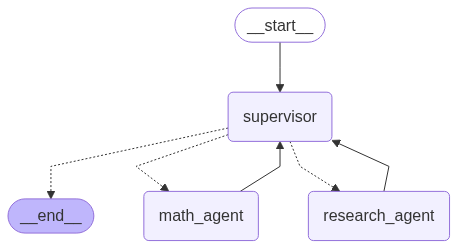

In [33]:
from IPython.display import display, Image

display(Image(supervisor.get_graph().draw_mermaid_png()))

In [49]:
for chunk in supervisor.stream(
    {"messages": [{"role": "user", "content": "Find US and New York State GDP in 2024. What % US GDP was New York State GDP?"}]}
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor


================================= Tool Message =================================
Name: transfer_to_research_agent

Successfully transferred to research_agent


Update from node research_agent


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor




Update from node supervisor


================================= Tool Message =================================
Name: transfer_to_math_agent

Successfully transferred to math_agent


Update from node math_agent


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor


================================== Ai Message ==================================
Name: supervisor

The Gross Domestic Product (GDP) of the United States in 2024 is approximately $28.5 trillion, while New York State's GDP is around $2.297 trillion. New York State's GDP represents approximately 8.06% of the US GDP.




In [50]:
for msg in final_message_history:
    pretty_print_message(msg)

================================ Human Message =================================

Find US and New York State GDP in 2024. What % US GDP was New York State GDP?
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_research_agent (call_jty0COih7JsFoCgIhK2k9HfP)
 Call ID: call_jty0COih7JsFoCgIhK2k9HfP
  Args:
================================= Tool Message =================================
Name: transfer_to_research_agent

Successfully transferred to research_agent
================================== Ai Message ==================================
Name: research_agent
Tool Calls:
  tavily_search (call_KA6w28cn97gBuxHh5aT9zgwM)
 Call ID: call_KA6w28cn97gBuxHh5aT9zgwM
  Args:
    query: US GDP 2024
    search_depth: advanced
  tavily_search (call_BWPj1QWHRsHaK5BcbvexRDd0)
 Call ID: call_BWPj1QWHRsHaK5BcbvexRDd0
  Args:
    query: New York State GDP 2024
    search_depth: advanced
================================= Tool Messag

## Create supervisor from scratch

1. Set up how the supervisor communicates with individual agents
2. Create the supervisor agent
3. Combine supervisor and worker agents into a single multi-agent graph.

In [55]:
from typing import Annotated
from langchain_core.tools import tool, InjectedToolCallId
from langgraph.prebuilt import InjectedState
from langgraph.graph import StateGraph, START, MessagesState
from langgraph.types import Command

# create a function for creating handoff tool to corresponding agent
def create_handoff_tool(*, agent_name: str, description: str | None = None):
    name = f"transfer_to_{agent_name}"
    description = description or f"Ask {agent_name} for help"

    @tool(name, description=description)
    def handoff_tool(
            state: Annotated[MessagesState, InjectedState],
            tool_call_id: Annotated[str, InjectedToolCallId],
    ) -> Command:
        tool_message = {
            "role": "tool",
            "content": f"Successfully transferred to {agent_name}",
            "name": name,
            "tool_call_id": tool_call_id
        }

        return Command(
            goto=agent_name,
            update={**state, "messages": state["messages"] + [tool_message]},
            graph=Command.PARENT
        )

    return handoff_tool

assign_to_research_agent = create_handoff_tool(
    agent_name="research_agent",
    description="Assign tasks to research agent"
)

assign_to_math_agent = create_handoff_tool(
    agent_name="math_agent",
    description="Assign tasks to math agent"
)

In [61]:
# create the supervisor agent
handmade_supervisor_agent = create_react_agent(
    model="openai:gpt-4o",
    tools=[assign_to_research_agent, assign_to_math_agent],
    prompt=(
        "You are a supervisor managing two agents:\n"
        "- a research agent. Assign research-related tasks to this agent\n"
        "- a math agent. Assign math-related tasks to this agent\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."
    ),
    name="handmade_supervisor_agent",
)

In [64]:
# create the graph and compile
from langgraph.graph import END

handmade_supervisor = (
    StateGraph(MessagesState)
    .add_node(handmade_supervisor_agent, destinations=("research_agent", "math_agent", END))
    .add_node(research_agent)
    .add_node(math_agent)
    .add_edge(START, "handmade_supervisor_agent")
    .add_edge("math_agent", "handmade_supervisor_agent")
    .add_edge("research_agent", "handmade_supervisor_agent")
    .compile()
)

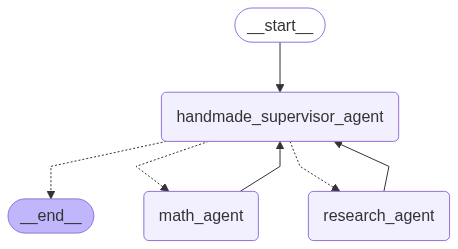

In [65]:
display(Image(handmade_supervisor.get_graph().draw_mermaid_png()))

In [68]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "Find US and New York State GDP in 2024. What % US GDP was New York State GDP?",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor


================================= Tool Message =================================
Name: transfer_to_research_agent

Successfully transferred to research_agent


Update from node research_agent


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor




Update from node supervisor


================================= Tool Message =================================
Name: transfer_to_math_agent

Successfully transferred to math_agent


Update from node math_agent


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor


================================== Ai Message ==================================
Name: supervisor

The Gross Domestic Product (GDP) of the United States in 2024 was approximately $26.68 trillion, and New York State's GDP was about $2.297 trillion. Consequently, New York State's GDP represented approximately 8.61% of the total US GDP in 2024.




In [69]:
for msg in final_message_history:
    pretty_print_message(msg)

================================ Human Message =================================

Find US and New York State GDP in 2024. What % US GDP was New York State GDP?
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_research_agent (call_VF48ywJZ2d1ELJmdBsmTyZMR)
 Call ID: call_VF48ywJZ2d1ELJmdBsmTyZMR
  Args:
================================= Tool Message =================================
Name: transfer_to_research_agent

Successfully transferred to research_agent
================================== Ai Message ==================================
Name: research_agent
Tool Calls:
  tavily_search (call_FxX47ul2WWXmgLzUMUMtbLRa)
 Call ID: call_FxX47ul2WWXmgLzUMUMtbLRa
  Args:
    query: US GDP 2024
    time_range: year
    search_depth: advanced
  tavily_search (call_ruF3V5FfEmMjT8h71ntCnywo)
 Call ID: call_ruF3V5FfEmMjT8h71ntCnywo
  Args:
    query: New York State GDP 2024
    time_range: year
    search_depth: advanced
===

## Delegation tasks

- In above supervisor, each time the supervisor passes control to worker agent, full message history is passed and worker agent bases on history to perform its task.

- We can make supervisor explicitly create tailored description for each task when passing the task to corresponding worker agent

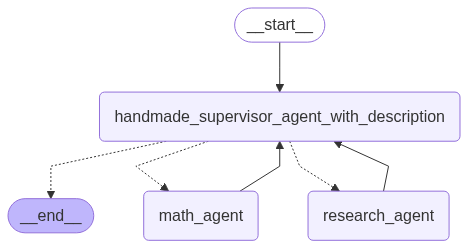

In [72]:
from langgraph.types import Send

def create_task_description_handoff_tools(
        *,
        agent_name: str,
        description: str | None = None,
):
    name = f"transfer_to_{agent_name}"
    description = description or f"Ask {agent_name} for help."

    @tool(name, description=description)
    def handoff_tool(
            task_description: Annotated[str, "Description of what the next agent should do, including all of the relevant context.",],
            state: Annotated[MessagesState, InjectedState],
    ):
        task_description_message = {"role": "user", "content": task_description}
        agent_input = {**state, "messages": task_description_message}
        return Command(
            goto=[Send(agent_name, agent_input)],
            graph=Command.PARENT
        )

    return handoff_tool

assign_to_research_agent_with_description = create_task_description_handoff_tools(
    agent_name="research_agent",
    description="Assign task to a research agent.",
)

assign_to_math_agent_with_description = create_task_description_handoff_tools(
    agent_name="math_agent",
    description="Assign task to a math agent.",
)

handmade_supervisor_agent_with_description = create_react_agent(
    model="openai:gpt-4o",
    tools=[
        assign_to_research_agent_with_description,
        assign_to_math_agent_with_description,
    ],
    prompt=(
        "You are a supervisor managing two agents:\n"
        "- A research agent. Assign research-related tasks to this assistant\n"
        "- A math agent. Assign math-related tasks to this assistant\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."
    ),
    name="handmade_supervisor_agent_with_description",
)

handmade_supervisor_with_description = (
    StateGraph(MessagesState)
    .add_node(
        handmade_supervisor_agent_with_description, destinations=("research_agent", "math_agent", END)
    )
    .add_node(research_agent)
    .add_node(math_agent)
    .add_edge(START, "handmade_supervisor_agent_with_description")
    .add_edge("research_agent", "handmade_supervisor_agent_with_description")
    .add_edge("math_agent", "handmade_supervisor_agent_with_description")
    .compile()
)

display(Image(handmade_supervisor_with_description.get_graph().draw_mermaid_png()))

In [73]:
for chunk in handmade_supervisor_with_description.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "Find US and New York state GDP in 2024. what % of US GDP was New York state?",
            }
        ]
    },
    subgraphs=True,
):
    pretty_print_messages(chunk, last_message=True)

Update from subgraph: handmade_supervisor_agent_with_description


	Update from node agent


	================================== Ai Message ==================================
	Name: handmade_supervisor_agent_with_description
	Tool Calls:
	  transfer_to_research_agent (call_RFv3cVvZHM3IXg8VS0H4tt0s)
	 Call ID: call_RFv3cVvZHM3IXg8VS0H4tt0s
	  Args:
	    task_description: Research the projected GDP for the US and New York state for the year 2024. Provide the numbers for both and any sources used to find this information.


Update from subgraph: research_agent


	Update from node agent


	================================== Ai Message ==================================
	Name: research_agent
	Tool Calls:
	  tavily_search (call_JidDrNSwZ8L4XYt3I1DMXXEk)
	 Call ID: call_JidDrNSwZ8L4XYt3I1DMXXEk
	  Args:
	    query: projected GDP for the US 2024
	    search_depth: advanced
	    topic: finance
	  tavily_search (call_8jxdAnEvANXi6oklkXVnIsEJ)
	 Call ID: call_8jxdAnEvANXi6oklkXVnIsEJ
	  Args:
	  